# 1. What is pruning and why does one need it
Much of the success of deep learning has come from building larger and larger neural networks. This allows these models to perform better on various tasks, but also makes them more expensive to use.

Neural network pruning is a method of compression that involves removing weights from a trained model.

## 1.1. What to prune
There are two types of pruning in terms of the elements to be pruned.

The unstructured pruning (pruning of weights) procedure eliminates (zeroes) the particular weights of neurons. Structured pruning (pruning of neurons) removes (can definitely remove) all weights of a neuron.


The significant benefit of structured pruning is that it truly speeds the model inference up while unstructured pruning requires sparse computation support in software and hardware (e.g. [neuralmagic](https://neuralmagic.com/)).

Illustration of both types of pruning is below.
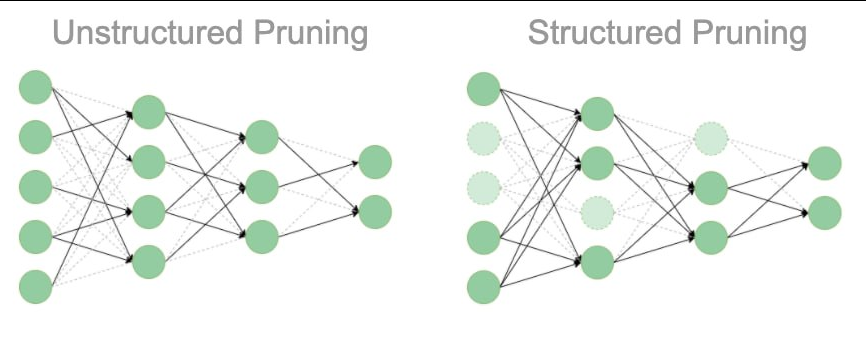

## 1.2 How to prune
The two most simple ways to select neurons for pruning are Weight Magnitude and Activation Magnitude (exclude random selection from account).

## 1.3. Where to prune
Possible levels of pruning are:

1) Layer (e.g. prune weights or kernels)

2) Block (e.g. prune entire layers)

3) Model (e.g. prune entire blocks)

## 1.4. When to prune
Pruning is usually done after model training is complete. The pruned model can be fine-tuned.


## 1.5. How to measure
When pruning a model one can consider the ratio of pruned parameters across a level (e.g. layer) or the entire model. The first ratio is called local, the second one is called global. In optimizing a model, the global ratio is pursued.


---



# 2. Tasks

## 2.0 Setup

Activate GPU if you're in Google Colab.

In [1]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [8]:
!gdown 1l96vcOWiAIXMOS9JdQKzpPIN8YfYfZkU

Downloading...
From (original): https://drive.google.com/uc?id=1l96vcOWiAIXMOS9JdQKzpPIN8YfYfZkU
From (redirected): https://drive.google.com/uc?id=1l96vcOWiAIXMOS9JdQKzpPIN8YfYfZkU&confirm=t&uuid=b55ebd4d-7051-4865-8c6c-b3db6beaf5ca
To: /kaggle/working/vgg19_bn.pt
100%|█████████████████████████████████████████| 156M/156M [00:01<00:00, 102MB/s]


In [44]:
# This command will download the weights of vgg_19
!gdown 1tkmJsGV7IPLfV1eXKWZKe_vncokcW_Gi

Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1tkmJsGV7IPLfV1eXKWZKe_vncokcW_Gi

but Gdown can't. Please check connections and permissions.


### 2.0.1 Define VGG model

In [9]:
"""The code is adapted from https://github.com/huyvnphan/PyTorch_CIFAR10/blob/master/cifar10_models/vgg.py
with minor changes in state_dict loading to use weights for CIFAR10.
"""

import os

import torch
import torch.nn as nn

class VGG(nn.Module):
    def __init__(self, features, num_classes=10, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {
    "A": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "B": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "D": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        "M",
    ],
    "E": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        512,
        "M",
    ],
}


def _vgg(arch, cfg, batch_norm, pretrained, progress, device, **kwargs):
    if pretrained:
        kwargs["init_weights"] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    if pretrained is not None:
        state_dict = torch.load(pretrained)
        model.load_state_dict(state_dict)
    return model


def vgg11_bn(pretrained=None, progress=True, device="cpu", **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg("vgg11_bn", "A", True, pretrained, progress, device, **kwargs)


def vgg13_bn(pretrained=None, progress=True, device="cpu", **kwargs):
    """VGG 13-layer model (configuration "B") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg("vgg13_bn", "B", True, pretrained, progress, device, **kwargs)


def vgg16_bn(pretrained=None, progress=True, device="cpu", **kwargs):
    """VGG 16-layer model (configuration "D") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg("vgg16_bn", "D", True, pretrained, progress, device, **kwargs)


def vgg19_bn(pretrained=None, progress=True, device="cpu", **kwargs):
    """VGG 19-layer model (configuration 'E') with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg("vgg19_bn", "E", True, pretrained, progress, device, **kwargs)

### 2.0.2 Install library and import packages

In [10]:
# Install the pruning library

!pip install torch-pruning
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 820.8 kB/s eta 0:00:00--:--


In [11]:
import torch
import torch.nn.functional as F
from torchvision.datasets import ImageNet
from torchvision.transforms import Compose, ToTensor, Normalize
import torch_pruning as tp
from pprint import pprint
import numpy as np
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchmetrics.functional.classification import multiclass_accuracy
from tqdm.notebook import tqdm

### 2.0.3 Define data and transforms

In [12]:
transforms = [
    ToTensor(),
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2471, 0.2435, 0.2616]),
]
transforms = Compose(transforms)

In [13]:
val_dataset = CIFAR10("./cifar10", train=False, download=True, transform=transforms)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:02<00:00, 75048502.13it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


### 2.0.4 Define validation function

In [14]:
def validate(model) -> float:
    if torch.cuda.is_available():
        device = "cuda"
        model = model.to(device)

    scores = []
    for x, y in tqdm(val_loader):
        with torch.no_grad():
            logits = model(x.to(device))
            probs = F.softmax(logits, dim=1)
            preds = probs.argmax(dim=1).cpu()
            score = multiclass_accuracy(preds, y, num_classes=10).item()
        scores.append(score)
    mean_score = np.mean(scores)
    # Return model to cpu to enable subsequent work
    model = model.cpu()
    return mean_score

### 2.0.5 Define state_dict path

In [20]:
STATE_DICT_PATH = "./vgg19_bn.pt"

### 2.0.6 Define example input requied by pruning library

In [16]:
example_inputs = torch.randn(1, 3, 32, 32)

## 2.1. Example №1

In [18]:
!ls -lh vgg19_bn.pt


-rw-r--r-- 1 root root 149M Mar 22 16:04 vgg19_bn.pt


In [21]:
demo_model = vgg19_bn(pretrained=STATE_DICT_PATH).eval()

In [22]:
pprint(demo_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [23]:
# Access to a model layer
pprint(demo_model.avgpool)

AdaptiveAvgPool2d(output_size=(1, 1))


In [24]:
# Access a model nested layer
pprint(demo_model.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [25]:
# Get the number of the layer filters

n_filters = demo_model.features[0].weight.shape[0]
print(n_filters)

64


In [26]:
# Compute model computational requirements (MACs) and a number of parameters to check if pruning works

macs_orig, nparams_orig = tp.utils.count_ops_and_params(demo_model, example_inputs)
print(f"MACs: {macs_orig}, number of parameters: {nparams_orig}")

MACs: 418400778.0, number of parameters: 38958922


In [27]:
# Build the model dependency graph for automatic pruning of connected layers

# Note: the graph should be reconstructed before every new pruning iteration since once the model is pruned its configuration is changed.

DG = tp.DependencyGraph()
DG.build_dependency(demo_model, example_inputs=example_inputs)

In [28]:
# Specify filters to be pruned.

pruning_idxs = [2, 6, 9, 10, 11, 12, 13]

In [29]:
pruning_group = DG.get_pruning_group(
    demo_model.features[0],  # Layer to be pruned
    tp.prune_conv_out_channels, # Use this one since convolutional layer is being pruned
    idxs=pruning_idxs,
)

if DG.check_pruning_group(pruning_group):
    pruning_group.exec()

/opt/conda/lib/python3.10/site-packages/torch_pruning/dependency.py:258: UserWarning: Group.exec() will be deprecated in the future. Please use Group.prune() instead.
  warnings.warn("Group.exec() will be deprecated in the future. Please use Group.prune() instead.")


In [30]:
# The number of parameters is less

macs, nparams = tp.utils.count_ops_and_params(demo_model, example_inputs)

macs_reduction = round((macs_orig - macs) / macs_orig * 100, 2)
nparams_reduction = round((nparams_orig - nparams) / nparams_orig * 100, 2)

print(f"MACs reduction: {macs_reduction}%, number of parameters reduction: {nparams_reduction}%")

MACs reduction: 1.04%, number of parameters reduction: 0.01%


## 2.2. Task №1

Prune from 10% to 20% of model weights by pruning convolutional layers.

Note:

1) Pruning of a filter involves reducing of weight tensor size in subseqent layers.

Example:

A convolutional weight has shape [C_OUT, C_IN, H, W].

W1 = [64, 32, 3, 3] and W2 = [128, 64, 3, 3] are weight of subsequent layers.

Pruning of W1 to [48, 32, 3, 3] leads to W2 becoming [128, 48, 3, 3].

2) Consider that the model contains not only convolutional layers but also other layers that contribute to the model parameters number.

In [31]:
task1_model = vgg19_bn(pretrained=STATE_DICT_PATH).eval()
_, nparams_orig_task1 = tp.utils.count_ops_and_params(task1_model, example_inputs)

In [32]:
model_layers = [
    task1_model.features[0],
    task1_model.features[3],
    task1_model.features[7],
    task1_model.features[10],
    task1_model.features[14],
    task1_model.features[17],
    task1_model.features[20],
    task1_model.features[23],
    task1_model.features[27],
    task1_model.features[30],
    task1_model.features[33],
    task1_model.features[36],
    task1_model.features[40],
    task1_model.features[43],
    task1_model.features[46],
    task1_model.features[49],
]

In [33]:
# Your code here
task1_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [34]:
RAND_SEED = 42
CHANNELS_PERCENT = 0.15
np.random.seed(RAND_SEED)

for idx, layer in enumerate(model_layers):
    DG_task1 = tp.DependencyGraph()
    DG_task1.build_dependency(
        task1_model,
        example_inputs=example_inputs
    )
    pruning_idxs = list(
        np.random.randint(
            0,
            layer.weight.shape[0],
            int(CHANNELS_PERCENT * layer.weight.shape[0]),
        )
    )
    pruning_group = DG_task1.get_pruning_group(
        model_layers[idx],          
        tp.prune_conv_out_channels, 
        idxs=pruning_idxs,
    )

    if DG_task1.check_pruning_group(pruning_group):
        pruning_group.exec()
     

In [35]:
_, nparams = tp.utils.count_ops_and_params(task1_model, example_inputs)
pruned_params_in_percents = (nparams_orig_task1 - nparams) / nparams_orig_task1 * 100
print(f"Parameters number decrease: {pruned_params_in_percents}%")
assert 10 <= pruned_params_in_percents <= 20

Parameters number decrease: 13.848722508287063%


## 2.3. Example №2

In [36]:
demo_model = vgg19_bn(pretrained=STATE_DICT_PATH).eval()

In [37]:
# Compute model computational requirements (MACs) and a number of parameters to check if pruning works

macs_orig, nparams_orig = tp.utils.count_ops_and_params(demo_model, example_inputs)
print(f"MACs: {macs_orig}, number of parameters: {nparams_orig}")

MACs: 418400778.0, number of parameters: 38958922


In [38]:
accuracy_orig = validate(demo_model)
print(f"Accuracy: {accuracy_orig}")

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy: 0.9364129601010851


In [39]:
# Calculate norm values for a layer filters.

with torch.no_grad():
    norms = [torch.norm(w, 2).item() for w in demo_model.features[0].weight]

In [40]:
# Select N filters with lowest norm (Weight Magnitude criterion)

pruning_ratio = 0.2
n_idx = int(round(pruning_ratio * len(norms)))

pruning_idxs = list(np.argsort(norms)[:n_idx])

print(f"Pruning indexes: {pruning_idxs}")

Pruning indexes: [53, 15, 56, 61, 63, 11, 28, 37, 10, 29, 22, 36, 60]


In [41]:
DG = tp.DependencyGraph()
DG.build_dependency(demo_model, example_inputs=example_inputs)
pruning_group = DG.get_pruning_group(
    demo_model.features[0],  # Layer to be pruned
    tp.prune_conv_out_channels, # Use this one since convolutional layer is being pruned
    idxs=pruning_idxs,
)

if DG.check_pruning_group(pruning_group):
    pruning_group.exec()

In [42]:
# Display results

macs, nparams = tp.utils.count_ops_and_params(demo_model, example_inputs)
accuracy = validate(demo_model)

accuracy_reduction = round((accuracy_orig - accuracy) / accuracy_orig * 100, 2)
macs_reduction = round((macs_orig - macs) / macs_orig * 100, 2)
nparams_reduction = round((nparams_orig - nparams) / nparams_orig * 100, 2)
print(f"Accuracy reduction: {accuracy_reduction}%")
print(f"MACs reduction: {macs_reduction}%, number of parameters reduction: {nparams_reduction}%")

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy reduction: -0.01%
MACs reduction: 1.93%, number of parameters reduction: 0.02%


## 2.4. Task №2

Prune from 10% to 20% of model weights by pruning convolutional layers with accuracy drop < 10%.

Note: it is possible that the pruned model will be more accurate than the non-pruned model.

In [43]:
task2_model = vgg19_bn(pretrained=STATE_DICT_PATH).eval()
accuracy_orig_task2 = validate(task2_model)
_, nparams_orig_task2 = tp.utils.count_ops_and_params(task2_model, example_inputs)

  0%|          | 0/157 [00:00<?, ?it/s]

In [44]:
model_layers = [
    task2_model.features[0],
    task2_model.features[3],
    task2_model.features[7],
    task2_model.features[10],
    task2_model.features[14],
    task2_model.features[17],
    task2_model.features[20],
    task2_model.features[23],
    task2_model.features[27],
    task2_model.features[30],
    task2_model.features[33],
    task2_model.features[36],
    task2_model.features[40],
    task2_model.features[43],
    task2_model.features[46],
    task2_model.features[49],
]

In [45]:
# Your code here
RAND_SEED = 42
CHANNELS_PERCENT = 0.15
np.random.seed(RAND_SEED)

for idx, layer in enumerate(model_layers):
    DG_task2 = tp.DependencyGraph()
    DG_task2.build_dependency(
        task2_model,
        example_inputs=example_inputs
    )
    
    pruning_idxs = [] 

    if idx > 7:
        pruning_idxs = list(
            np.random.randint(
                0,
                layer.weight.shape[0],
                int(CHANNELS_PERCENT * layer.weight.shape[0]),
            )
        )
    pruning_group = DG_task2.get_pruning_group(
        model_layers[idx],          
        tp.prune_conv_out_channels, 
        idxs=pruning_idxs,
    )

    if DG_task2.check_pruning_group(pruning_group):
        pruning_group.exec()

In [46]:
_, nparams = tp.utils.count_ops_and_params(task2_model, example_inputs)
pruned_params_in_percents = (nparams_orig_task2 - nparams) / nparams_orig_task2 * 100
accuracy = validate(task2_model)
accuracy_decrease_in_percents = (accuracy_orig_task2 - accuracy) / accuracy_orig_task2 * 100
print(f"Accuracy decrease: {accuracy_decrease_in_percents}%")
print(f"Parameters number decrease: {pruned_params_in_percents}%")
assert 10 <= pruned_params_in_percents <= 20
assert accuracy_decrease_in_percents < 10

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy decrease: 0.19915758749699822%
Parameters number decrease: 11.994618331585253%
